In [ ]:
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision.io import read_image
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import tqdm
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset_path = "/content/drive/MyDrive/datasets/ml_footbal/dataset"
dataset_path = "/content/drive/MyDrive/ml_project/ml_footbal/dataset"

df = pd.read_csv(f"{'/'.join(dataset_path.split('/')[:-1])}/jersey.csv")
imgs = os.listdir(dataset_path)
classes = pd.unique(df["jersey_number"])
num_classes = len(classes)
print(f"Number of imgs: {len(imgs)}. Number of classes: {num_classes}")


Number of imgs: 5086. Number of classes: 19


In [ ]:
classes

array([ 5, 10, 19, 32, 20, 17,  6, 29,  9, 28, 26, 27,  4,  7,  2, 16, 47,
        3,  8])

In [ ]:
df[df["jersey_number"] == 0]

,num,filename,team,jersey_number


In [ ]:

class FootballDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_dir = dataset_path
        df = pd.read_csv(f"{'/'.join(dataset_path.split('/')[:-1])}/jersey.csv")
        self.img_paths = df["filename"].to_numpy()
        self.labels = df["jersey_number"].to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = f"{self.dataset_dir}/{self.img_paths[idx].split('/')[-1]}"
        label = self.labels[idx]
        image = np.array(Image.open(img_path))

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),
    transforms.ToTensor(),
])


batch_size = 32

dataset = FootballDataset(dataset_path, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Number of images: {len(train_dataset)}")

Number of images: 4080


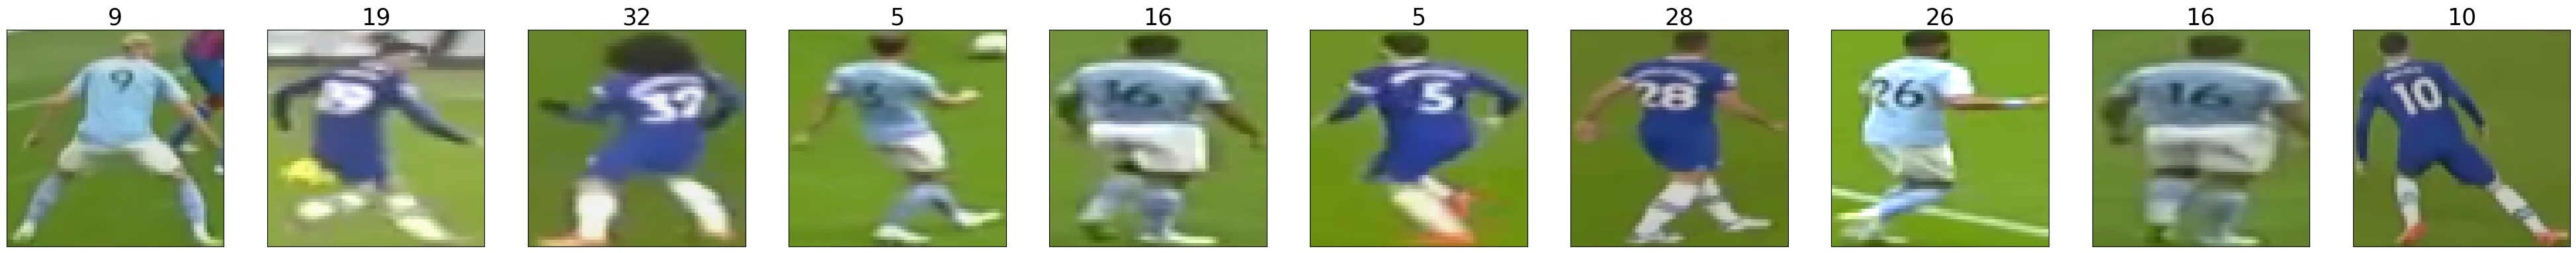

In [ ]:

fig = plt.figure(figsize=(50, 20))
num_imgs = 10
rand_indexes = [random.randint(0, len(train_dataset) - 1) for _ in range(num_imgs)]
for idx in np.arange(num_imgs):
    ax = fig.add_subplot(2, num_imgs, idx+1, xticks=[], yticks=[])
    ax.imshow(train_dataset[rand_indexes[idx]][0].permute(1, 2, 0) )
    ax.set_title(str(train_dataset[rand_indexes[idx]][1]), fontsize=25)

In [ ]:
class FootballCNN(nn.Module):
    def __init__(self, num_classes=19):
        super(FootballCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            # result after conv2d is 16x64x64
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #result after maxpool is 16x32x32

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # 32x32x32
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32x16x16


            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # 64x16x16
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64x8x8

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            #128x828
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #128x4x4
         )
        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
            # nn.Softmax(dim=1),
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x





In [ ]:
from sklearn import metrics
from torch import Tensor
class Evaluator:
  def __init__(self, model):
    self.model = model

  def forward(self, model, loader):
      output = {}
      device = next(model.parameters()).device
      predicted_lst = []
      predicted_labels = []
      targets = []
      losses = []
      for i, (images, labels) in enumerate(loader):
          images = images.to(device)
          labels = labels.to(device)
          targets.extend(labels)
          with torch.no_grad():
              outputs = model(images)
          loss = criterion(outputs, labels)
          losses.append(loss.item())
          predicted_lst.append(outputs.to("cpu"))
          _, predicted = torch.max(outputs.data, 1)
          predicted_labels.extend(predicted.to("cpu"))

      loss = np.mean(losses)
      output['clipwise_output'] = predicted_lst
      output['labels'] = predicted_labels
      output['target'] = targets
      output['loss'] = loss

      return output

  def evaluate(self, loader):
    predictions = self.forward(
        model=self.model,
        loader=loader)
    
    clipwise_output = predictions['clipwise_output']
    labels = predictions['labels']
    target = predictions['target']

    target = np.array(Tensor.cpu(Tensor(target)))
    clipwise_output = np.array(clipwise_output)
    # clipwise_output = Tensor(clipwise_output).detach().cpu().numpy()
    labels = np.array(Tensor.cpu(Tensor(labels)))
    # print(type(target), type(clipwise_output))
    # mAP = metrics.average_precision_score(target, clipwise_output, average=None)
    acc = metrics.accuracy_score(target, labels, normalize=True)
    f1 = metrics.f1_score(target, labels, average=None)
    loss = predictions['loss']
    statistics = {'acc': acc, 'f1': f1, 'loss': loss}

    return statistics


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
model = FootballCNN(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cpu")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/128], Loss: 0.9406


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 10%|█         | 1/10 [25:24<3:48:37, 1524.14s/it]

Epoch [2/10], Step [100/128], Loss: 0.2226


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 20%|██        | 2/10 [25:56<1:26:13, 646.66s/it] 

Epoch [3/10], Step [100/128], Loss: 0.1063


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 30%|███       | 3/10 [26:28<42:42, 366.02s/it]  

Epoch [4/10], Step [100/128], Loss: 0.2527


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 40%|████      | 4/10 [27:01<23:26, 234.45s/it]

Epoch [5/10], Step [100/128], Loss: 0.1086


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 50%|█████     | 5/10 [27:33<13:27, 161.40s/it]

Epoch [6/10], Step [100/128], Loss: 0.0292


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 60%|██████    | 6/10 [28:08<07:54, 118.52s/it]

Epoch [7/10], Step [100/128], Loss: 0.0061


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 70%|███████   | 7/10 [28:44<04:34, 91.41s/it] 

Epoch [8/10], Step [100/128], Loss: 0.1593


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 80%|████████  | 8/10 [29:17<02:26, 73.07s/it]

Epoch [9/10], Step [100/128], Loss: 0.0335


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 90%|█████████ | 9/10 [29:52<01:01, 61.13s/it]

Epoch [10/10], Step [100/128], Loss: 0.0172


<ipython-input-11-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-11-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
100%|██████████| 10/10 [30:27<00:00, 182.75s/it]


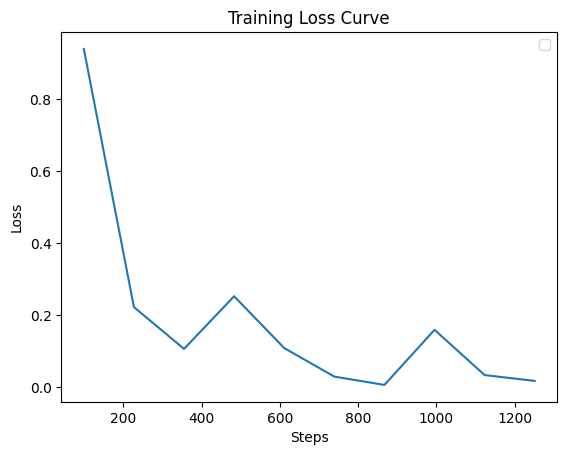

In [ ]:
num_epochs = 10

total_steps = len(train_loader)
losses = []
steps = []
statistics = []
evaluator = Evaluator(model=model)
model.train()
for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        # Print training progress
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            steps.append(epoch * total_steps + i)

    test_statistics = evaluator.evaluate(val_loader)
    statistics.append(test_statistics)
    
plt.plot(steps, losses)
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()

FootballCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [ ]:
predictions = []
true_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm.tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # print("!!!", labels, "\n", outputs.data.shape, "\n", outputs.data, "\n",  predicted, "\n\n")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
    print(f'\nTest Accuracy: {(correct/total)*100:.2f}%')

100%|██████████| 32/32 [00:04<00:00,  7.71it/s]


Test Accuracy: 96.38%


10


<Axes: >

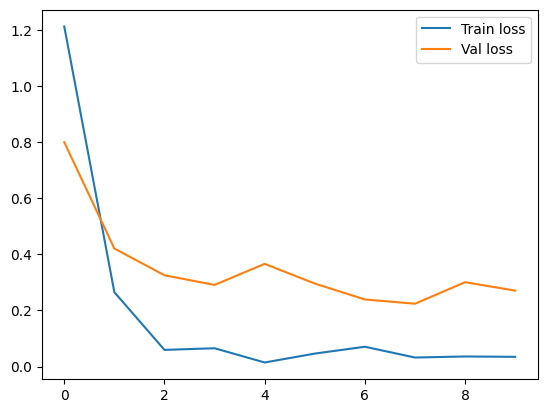

In [ ]:
import seaborn as sns
print(len(losses))
val_losses = [stat['loss'] for stat in statistics]
plt.figure()
sns.lineplot(losses, label='Train loss')
sns.lineplot(val_losses, label='Val loss')

<Axes: xlabel='labels', ylabel='amounts'>

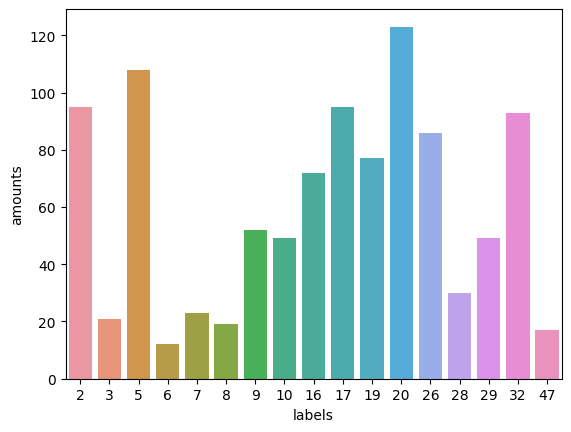

In [ ]:
import pandas as pd
val_labels = []
for i, (_, labels) in enumerate(val_loader):
          val_labels.extend(labels)
labels, amounts = np.unique(np.array(val_labels), return_counts=True)

df = pd.DataFrame()
df['labels'] = labels
df['amounts'] = amounts

plt.figure()
sns.barplot(data=df, x='labels', y='amounts')


<Axes: >

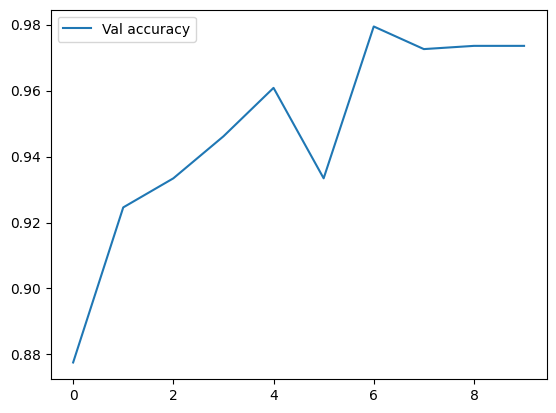

In [ ]:
val_acc = [stat['acc'] for stat in statistics]
plt.figure()
sns.lineplot(val_acc, label='Val accuracy')

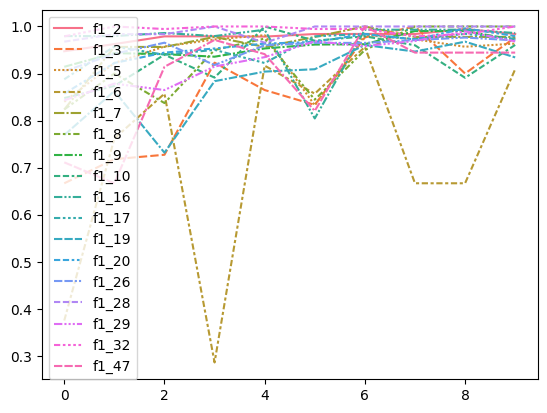

In [ ]:
f1_scores = []
df = pd.DataFrame()
for idx, label in enumerate(labels):
    f1_score = [stat['f1'][idx] for stat in statistics]
    df[f'f1_{label}'] = f1_score

plt.figure()
sns.lineplot(df)
plt.legend(loc='upper left')

In [ ]:
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(cf, 
                          group_names=None, 
                          categories='auto', 
                          count=True, 
                          percent=True, 
                          cbar=True, 
                          xyticks=True, 
                          xyplotlabels=True, 
                          sum_stats=True, 
                          figsize=None, 
                          cmap='Blues', 
                          title=None): 
    ''' 
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization. 
    Arguments 
    --------- 
    cf:            confusion matrix to be passed in 
    group_names:   List of strings that represent the labels row by row to be shown in each square. 
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto' 
    count:         If True, show the raw number in the confusion matrix. Default is True. 
    normalize:     If True, show the proportions for each category. Default is True. 
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix. 
                   Default is True. 
    xyticks:       If True, show x and y ticks. Default is True. 
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True. 
    sum_stats:     If True, display summary statistics below the figure. Default is True. 
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value. 
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues' 
                   See http://matplotlib.org/examples/color/colormaps_reference.html 
                    
    title:         Title for the heatmap. Default is None. 
    ''' 
 
 
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE 
    blanks = ['' for i in range(cf.size)] 
 
    if group_names and len(group_names)==cf.size: 
        group_labels = ["{}\n".format(value) for value in group_names] 
    else: 
        group_labels = blanks 
 
    if count: 
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()] 
    else: 
        group_counts = blanks 
 
    if percent: 
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)] 
    else: 
        group_percentages = blanks 
 
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)] 
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1]) 
 
 
    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS 
    if sum_stats: 
        #Accuracy is sum of diagonal divided by total observations 
        accuracy  = np.trace(cf) / float(np.sum(cf)) 
 
        #if it is a binary confusion matrix, show some more stats 
        if len(cf)==2: 
            #Metrics for Binary Confusion Matrices 
            precision = cf[1,1] / sum(cf[:,1]) 
            recall    = cf[1,1] / sum(cf[1,:]) 
            f1_score  = 2*precision*recall / (precision + recall) 
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format( 
                accuracy,precision,recall,f1_score) 
        else: 
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy) 
    else: 
        stats_text = "" 
 
 
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS 
    if figsize==None: 
        #Get default figure size if not set 
        figsize = plt.rcParams.get('figure.figsize') 
 
    if xyticks==False: 
        #Do not show categories if xyticks is False 
        categories=False 
 
 
    # MAKE THE HEATMAP VISUALIZATION 
    plt.figure(figsize=figsize) 
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)  # type: ignore 
 
    if xyplotlabels: 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label' + stats_text) 
    else: 
        plt.xlabel(stats_text) 
     
    if title:
        plt.title(title) 
 

def create_confusion_matrix(pred, labels): 
    
    lst = [] 
    lst.extend(pred) 
    lst.extend(labels) 
    all_classes = list(set(lst)) 
     
    matrix = confusion_matrix(labels, pred, labels=all_classes) 
    
    img = make_confusion_matrix(matrix, categories=all_classes) 
    plt.show()

pred = []
labels = []
for images, labels in val_loader:
    images_dev = images.to(device)
    labels_dev = labels.to(device)
    labels.extend(labels_dev)
    outputs = model(images_dev)
    
    _, predicted = torch.max(outputs.data, 1)
    pred.extend(predicted)
    

confusion_matrix = create_confusion_matrix(pred, labels)

NameError: ignored

In [ ]:
import random

torch.Size([32, 3, 64, 64])
<class 'torch.Tensor'>
torch.Size([32]) torch.Size([32, 100])


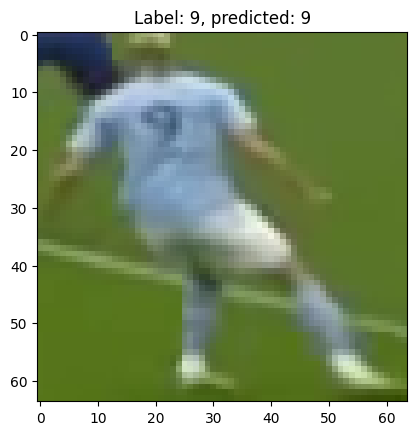

!!! tensor(9) 
 torch.Size([100]) 
 tensor([ -9.9403, -10.0561,  -0.5639,   2.2785, -18.9622,   3.4475, -12.6370,
          4.5330,   1.9557,  12.1682,  -1.8859,  -9.0811,  -9.9781,  -8.5401,
         -9.7724, -10.6717,   3.0088,   6.4284,  -8.0523,  -5.9774,  -4.1495,
         -8.9741,  -8.1074,  -8.0066,  -8.6500,  -8.7672,  -7.2332, -11.8807,
         -4.3113,  -5.1885,  -9.0355,  -9.0947,  -3.1184,  -8.8216,  -8.1402,
         -9.6578,  -9.4893,  -7.6124,  -9.5348,  -9.4861,  -9.9460,  -8.4975,
         -9.5530,  -9.7347,  -8.3337,  -8.5592,  -6.9069,   1.3800,  -8.6224,
         -8.5595,  -8.0896,  -9.3316,  -7.7441,  -8.5917,  -8.5576,  -9.9869,
         -9.1544,  -9.3150,  -9.8864,  -8.5028,  -7.2839,  -7.6990,  -8.4752,
         -8.7902,  -9.3447,  -7.6615, -10.4277,  -9.9105,  -7.9413,  -9.4956,
         -8.7409, -10.1842,  -8.5637,  -9.3453,  -8.0559,  -8.1460,  -9.9607,
         -9.0310, -10.2526,  -8.1248, -11.2474,  -8.6932,  -9.1065,  -7.8765,
        -10.3951,  -7.4393, 

In [ ]:
for images, labels in val_loader:
    images_dev = images.to(device)
    labels_dev = labels.to(device)
    print(images_dev.shape)
    outputs = model(images_dev)
    print(type(outputs))
    i = 15
    _, predicted = torch.max(outputs.data, 1)
    print(predicted.shape, outputs.data.shape)

    plt.imshow(images[i].squeeze().permute(1, 2, 0), cmap="gray")
    plt.title(f"Label: {labels[i].item()}, predicted: {predicted[i].item()}")
    plt.show()

    print("!!!", labels[i], "\n", outputs.data[i].shape, "\n", outputs.data[i], torch.max(outputs.data[i], 0), "\n",  predicted[i], "\n\n")

    break


In [ ]:
torch.save(model.state_dict(), f"{'/'.join(dataset_path.split('/')[:-1])}/model/jersey_model.pt")

In [ ]:
f"{'/'.join(dataset_path.split('/')[:-1])}/model/jersey_model.pt"

'/content/drive/MyDrive/datasets/ml_footbal/model/jersey_model.pt'

In [ ]:
def get_prediction(img_filename, model):
    image = np.array(Image.open(img_filename))
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.reshape(-1, image.shape[0], image.shape[1], image.shape[2] )
    
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    return predicted.item()


In [ ]:
get_prediction(f"{dataset_path}/Chelsea__Bournemouth_1070_2.png", model)

torch.Size([1, 3, 64, 64])


5

# Team classification

In [ ]:

class FootballDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_dir = dataset_path
        df = pd.read_csv(f"{'/'.join(dataset_path.split('/')[:-1])}/jersey.csv")
        self.img_paths = df["filename"].to_numpy()
        self.labels = df["team"].to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = f"{self.dataset_dir}/{self.img_paths[idx].split('/')[-1]}"
        label = self.labels[idx]
        image = np.array(Image.open(img_path))

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


batch_size = 32

dataset = FootballDataset(dataset_path, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Number of images: {len(train_dataset)}")

Number of images: 4080


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
model = FootballCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/128], Loss: 0.0001


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 10%|█         | 1/10 [00:12<01:51, 12.34s/it]

Epoch [2/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 20%|██        | 2/10 [00:24<01:35, 11.98s/it]

Epoch [3/10], Step [100/128], Loss: 0.0002


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 30%|███       | 3/10 [00:35<01:22, 11.76s/it]

Epoch [4/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 40%|████      | 4/10 [00:47<01:09, 11.65s/it]

Epoch [5/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 50%|█████     | 5/10 [00:58<00:58, 11.62s/it]

Epoch [6/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 60%|██████    | 6/10 [01:10<00:46, 11.64s/it]

Epoch [7/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 70%|███████   | 7/10 [01:21<00:34, 11.63s/it]

Epoch [8/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 80%|████████  | 8/10 [01:33<00:23, 11.65s/it]

Epoch [9/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
 90%|█████████ | 9/10 [01:45<00:11, 11.67s/it]

Epoch [10/10], Step [100/128], Loss: 0.0000


<ipython-input-30-1765c44b8793>:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  clipwise_output = np.array(clipwise_output)
<ipython-input-30-1765c44b8793>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clipwise_output = np.array(clipwise_output)
100%|██████████| 10/10 [01:56<00:00, 11.68s/it]


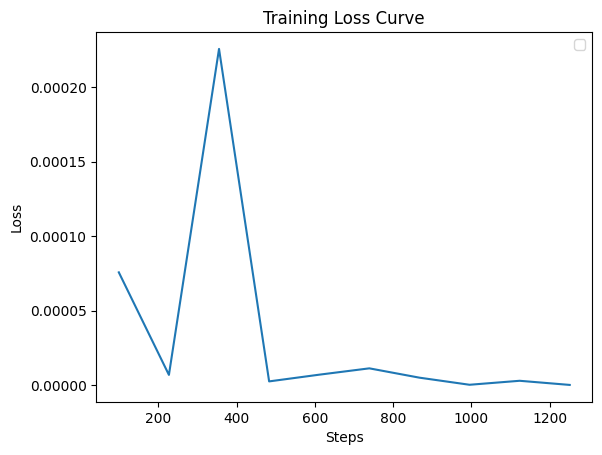

In [ ]:
num_epochs = 10

total_steps = len(train_loader)
losses = []
steps = []
statistics = []
evaluator = Evaluator(model=model)
model.train()
for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        # Print training progress
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            steps.append(epoch * total_steps + i)

    test_statistics = evaluator.evaluate(val_loader)
    statistics.append(test_statistics)
            
plt.plot(steps, losses)
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

10


<Axes: >

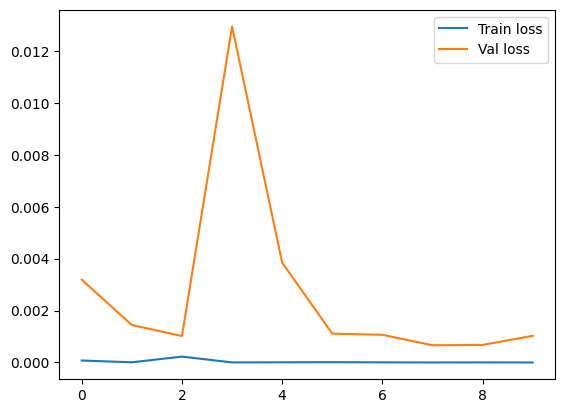

In [ ]:
import seaborn as sns
print(len(losses))
val_losses = [stat['loss'] for stat in statistics]
plt.figure()
sns.lineplot(losses, label='Train loss')
sns.lineplot(val_losses, label='Val loss')

<Axes: xlabel='labels', ylabel='amounts'>

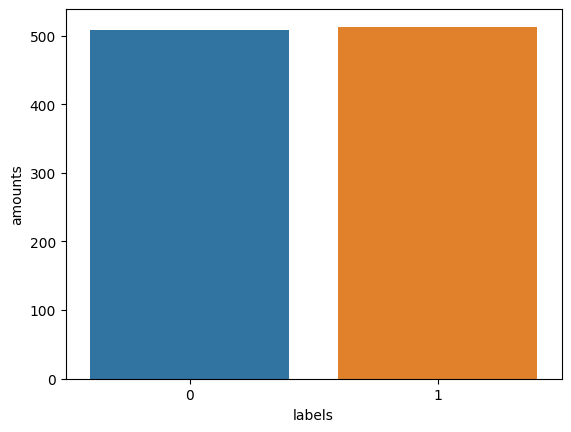

In [ ]:
import pandas as pd
val_labels = []
for i, (_, labels) in enumerate(val_loader):
          val_labels.extend(labels)
labels, amounts = np.unique(np.array(val_labels), return_counts=True)

df = pd.DataFrame()
df['labels'] = labels
df['amounts'] = amounts

plt.figure()
sns.barplot(data=df, x='labels', y='amounts')

<Axes: >

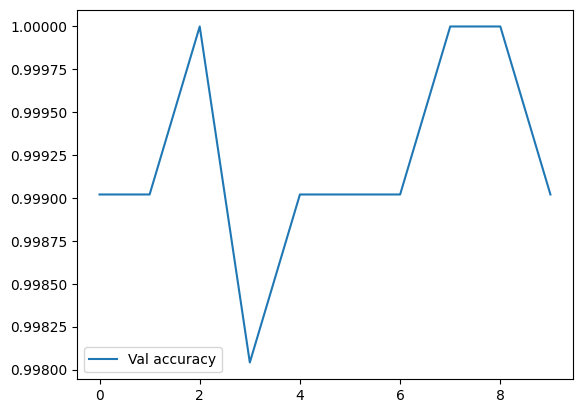

In [ ]:
val_acc = [stat['acc'] for stat in statistics]
plt.figure()
sns.lineplot(val_acc, label='Val accuracy')

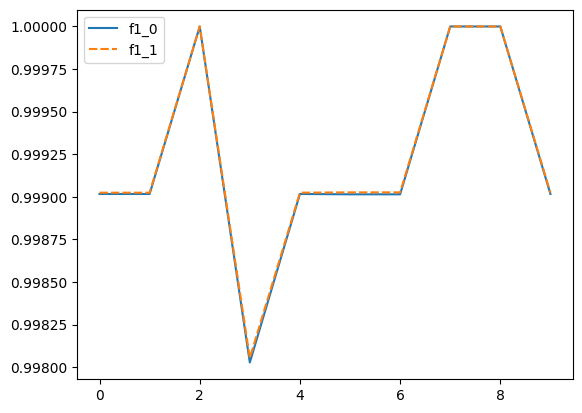

In [ ]:
f1_scores = []
df = pd.DataFrame()
for idx, label in enumerate(labels):
    f1_score = [stat['f1'][idx] for stat in statistics]
    df[f'f1_{label}'] = f1_score

plt.figure()
sns.lineplot(df)
plt.legend(loc='upper left')

In [ ]:
predictions = []
true_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm.tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # print("!!!", labels, "\n", outputs.data.shape, "\n", outputs.data, "\n",  predicted, "\n\n")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
    print(f'\nTest Accuracy: {(correct/total)*100:.2f}%')

100%|██████████| 32/32 [04:06<00:00,  7.72s/it]


Test Accuracy: 100.00%


In [ ]:
torch.save(model.state_dict(), f"{'/'.join(dataset_path.split('/')[:-1])}/model/team_model.pt")